<a href="https://colab.research.google.com/github/foukonana/Diabetes/blob/master/CURE_try1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark
from pyspark import SparkContext

In [3]:
sc = SparkContext('local[*]')

In [4]:
#data_file = '/content/drive/MyDrive/input/*'
data_file = '/content/drive/MyDrive/BigData/data_size1/data1.txt'

# load the data and parse into "x" and "y" values for each entry
rdd = sc.textFile(data_file)\
    .map(lambda f: f.split(","), True)\
    .map(lambda x: (float(x[0]), float(x[1])))
rdd.persist()

from pyspark.shell import spark
df = spark.createDataFrame(rdd, ["x", "y"])
df = df.distinct()

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.1.2
      /_/

Using Python version 3.7.10 (default, May  3 2021 02:48:31)
Spark context Web UI available at http://2c324c2a69c1:4040
Spark context available as 'sc' (master = local[*], app id = local-1623488126037).
SparkSession available as 'spark'.


In [5]:
# keep the quartile values for each of the dataframe columns 
# find the interquartile range and define if a point is an outlier or not to later decide and keep it 
bounds = {
    column_name: dict(
        zip(["q1", "q3"], df.approxQuantile(column_name, [0.25, 0.75], 0))
    )
    for column_name in df.columns
}

for column_name in bounds.keys():
    iqr = bounds[column_name]['q3'] - bounds[column_name]['q1']
    bounds[column_name]['lower'] = bounds[column_name]['q1'] - (iqr * 1.5)
    bounds[column_name]['upper'] = bounds[column_name]['q3'] + (iqr * 1.5)

import pyspark.sql.functions as f
df = df.select(
    "*",
    *[
        f.when(
            f.col(column_name).between(bounds[column_name]['lower'], bounds[column_name]['upper']),
            0
        ).otherwise(1).alias("out") 
        for column_name in df.columns
    ]
)

filtered_data_rdd = df.rdd\
    .filter(lambda x: x[2] == 0)\
    .map(lambda x: (x[0], x[1]))
filtered_data_rdd.persist()

PythonRDD[37] at RDD at PythonRDD.scala:53

In [6]:
# https://github.com/Kchu/CURE-cluster-python/blob/master/CURE.py (mostly this)
# https://github.com/deric/data-mining-cure-algorithm/blob/master/src/main/java/org/fmi/data/mining/cure/Cure.java (this is also good but is java, use as guideline)
# https://github.com/jiajunwang22/Clustering_cure/blob/master/Jiajun_Wang_cure.py (this not so much, just guidance)
# i need to keep my shit together for this...

# https://github.com/kmavropou/Cure-Spark-Java/blob/master/Main.java (MAYBE DIS)

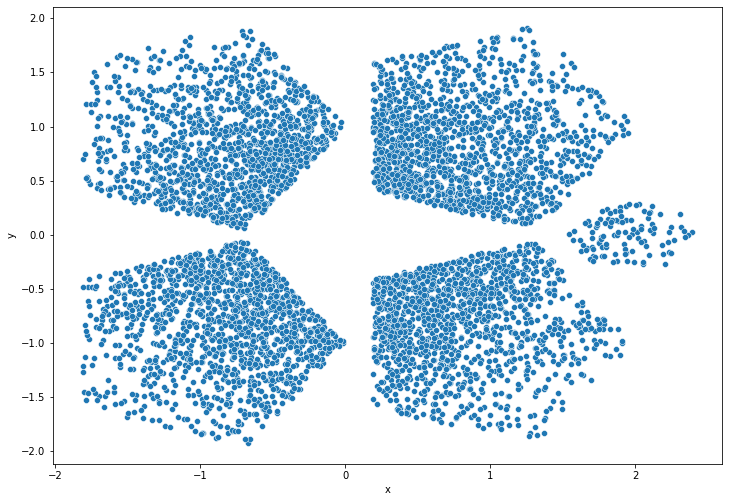

In [7]:
# maybe keep this one on the analysis workbook?

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data_pd = filtered_data_rdd.toDF(["x", "y"]).toPandas()

plt.figure(figsize=(12, 8.4))
sns.scatterplot(data=filtered_data_pd, x="x", y="y")

In [8]:
# initate CURE using hierarchical clustering 
from sklearn.cluster import AgglomerativeClustering
import pandas as pd

# load a standard amount of data points in main memory and cluster them 
N_POINTS = 3500
N_CLUSTERS = 5
SEED = 459

sample_perc = N_POINTS/ filtered_data_rdd.count()
sample_perc=0.33
sample_data_rdd = filtered_data_rdd.sample(False, sample_perc, SEED)
sample_data_rdd.persist()

def cluster_sample_points(df, n_clusters=N_CLUSTERS):
    """
    df: pd.DataFrame of the x and y coordinates of the points 
    n_clusters: the initial number of clusters to initialize the algorithm
    """
    points_to_cluster = df.values
    x_coords = df.iloc[:, 0].to_numpy()
    y_coords = df.iloc[:, 1].to_numpy()

    # run hierachical clustering -- affinity and linkage predifined
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity="mahalanobis", linkage="complete")
    cluster_membership = clusterer.fit_predict(points_to_cluster)
    clusters={'x': x_coords,
            'y': y_coords,
            'cluster_id': cluster_membership}
    cluster_members_pd = pd.DataFrame(data=clusters)

    return cluster_members_pd

cluster_members_pd = cluster_sample_points(sample_data_rdd.toDF().toPandas(), N_CLUSTERS)

# TODO  
Filter the data to only keep the values that are not in the original data sample

In [9]:
# # keep the values that are not in the original data 
# for sample_line in sample_data_rdd.collect():
#     data_rdd = filtered_data_rdd.filter(lambda line: line != sample_line)

In [10]:
rdd3 = spark.createDataFrame(cluster_members_pd).rdd
rdd3.persist()

MapPartitionsRDD[62] at javaToPython at NativeMethodAccessorImpl.java:0

In [11]:
import numpy as np

def collectPoints(points):
    """
    Takes a list of points and returns them as a list of clusters
    """
    returnedPoints = []
    for point in points:
        returnedPoints.append(point[0])
    return returnedPoints

# list of tuples in the form of (x_coord y_coord) for every predicted cluster id 
preds = rdd3.map(lambda x: ((x[0], x[1]), x[2]))\
    .groupBy(lambda x: x[1])\
    .mapValues(lambda x: collectPoints(x))

In [15]:
preds.toDF().toPandas()

,_1,_2
0,2,"[(0.36577, -0.55548), (1.194, -1.7537), (1.143..."
1,0,"[(-0.62675, -0.82141), (-0.29375, -0.84793), (..."
2,4,"[(1.6689, -0.11991), (1.8967, 0.25218), (1.995..."
3,1,"[(0.83192, 0.70899), (0.35631, 0.6375), (1.241..."
4,3,"[(-0.71195, 0.56759), (-0.94283, 1.1756), (-0...."


After the initialization of CURE algorithm with the clustering of a sample of points, we need to run the following steps:
* Select a small set of representative points per clusters. They sould be as disperced as possible (following [this](https://flothesof.github.io/farthest-neighbors.html))
* Move each of the representatives by a fraction of the distance between its location and the centroid of its cluster

And that complets the first phase of CURE

## Warning
It is not clear in the notes/ book if the cluster centroid should be calculated from all the cluster points or by the cluster representatives.  
Here we are calculating the cluster's centroid using all the cluster values (since we are only using a sample from the data) 

In [12]:
import random
from numpy import sqrt, abs

POINT_CENTROID_DIST_FRACTION = 0.2


def euclidean_dist(x, y): return sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)


def find_cluster_centroid(cluster_members):
    """
    Find and return the centroid of the cluster -- the mean of the cluster members -- does not have to be actual point in the cluster
    """
    x_coords_summed, y_coords_summed = 0, 0
    for cluster_member in cluster_members:
        x_coords_summed += cluster_member[0]
        y_coords_summed += cluster_member[1]

    n_clutser_members = len(cluster_members)
    cluster_centroid = (x_coords_summed/n_clutser_members, y_coords_summed/n_clutser_members)

    return cluster_centroid


def select_disperce_representative_points(cluster_members, n_representatives):
    """
    TODO --  add a section that explains how the representatives are selectes
    """
    print(cluster_members)
    remaining_points = cluster_members[:]
    representatives_set = []
    # randomly add the first point on the set of representatives
    representatives_set.append(remaining_points.pop(\
                                random.randint(0, len(remaining_points) - 1)))

    for _ in range(n_representatives-1):
        distances = [euclidean_dist(point, representatives_set[0]) for point in remaining_points]
        for i, point in enumerate(remaining_points):
            for j, representative in enumerate(representatives_set):
                distances[i] = min(distances[i], euclidean_dist(point, representative))
        representatives_set.append(remaining_points.pop(distances.index(max(distances))))

    return representatives_set


def move_points_close_to_centroid(cluster_members, cluster_centroid, distance_fraction):
    """
    TODO
    """
    moved_cluster_points = list()
    for cluster_member in cluster_members:
        moved_member = (cluster_member[0] - distance_fraction*(cluster_member[0] - cluster_centroid[0]),
                        cluster_member[1] - distance_fraction*(cluster_member[1] - cluster_centroid[1]))
        moved_cluster_points.append(moved_member)
    
    return moved_cluster_points


# wrap the steps together to complete the 1st pass of CURE
def final_cluster_representatives(cluster_members, n_representatives, distance_fraction):
    """
    A wrapper function of the 3 previously defined functions
    """
    # find the cluster's centroid
    cluster_centroid = find_cluster_centroid(cluster_members)
    # select representatives for that cluster 
    cluster_representative_points = select_disperce_representative_points(cluster_members, n_representatives)
    # and finaly move them closer to the centroid
    final_moved_representatives = move_points_close_to_centroid(cluster_representative_points, cluster_centroid, distance_fraction)

    return final_moved_representatives

## TODO
Check what happens if the number of representative points that are asked are larger than the number of points that belong to the cluster 

In [18]:
cluster_representatives_rdd = preds.\
        mapValues(lambda x: final_cluster_representatives(x, n_representatives=30, distance_fraction=0.2))
cluster_representatives_rdd.persist()

PythonRDD[84] at RDD at PythonRDD.scala:53

In [19]:
def return_self(x): return x

flat_cluster_representatives = sc.broadcast(cluster_representatives_rdd.flatMapValues(return_self).collect())

In [20]:
def clusterer(new_point, cluster_representatives):
    """
    cluster_representatives: (cluster_id, [representative_points])
    """

    min_distance = float('inf')
    minclust = -1

    for representative in cluster_representatives:
        point_repr_distance = euclidean_dist(representative[1], new_point)
        if point_repr_distance < min_distance:
            min_distance = point_repr_distance
            minclust = representative[0]
    return minclust


assigned_clusters = filtered_data_rdd.map(lambda x: (x, clusterer(x, flat_cluster_representatives.value)))
assigned_clusters = assigned_clusters.map(lambda x: (x[0][0], x[0][1], x[1]))
results_cure = assigned_clusters.toDF(["x", "y", "cluster_id"]).toPandas()

cluster_representatives_pd = cluster_representatives_rdd.flatMapValues(return_self).map(lambda x: (x[1][0], x[1][1], x[0])).toDF(["x", "y", "cluster_id"]).toPandas()

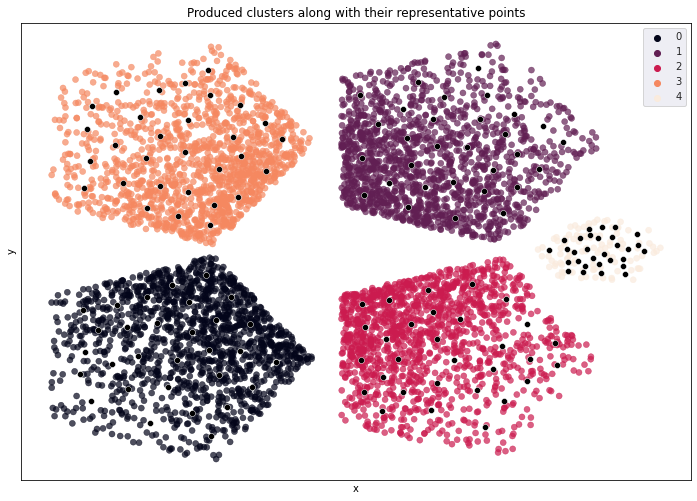

In [21]:
# plot the resulting clusters 
plt.figure(figsize=(12, 8.4))
plt.title('Produced clusters along with their representative points')

sns.set_style('dark')
sns.axes_style('whitegrid')
splot1 = sns.scatterplot(data=results_cure, x='x', y='y', hue='cluster_id', edgecolor=None, palette='rocket', alpha=0.7)
splot1.set(xticks=[], yticks=[], xlabel='x', ylabel='y')
plt.legend(loc='lower center', ncol=5)
# add the representatives of each cluster 
splot2 = sns.scatterplot(data=cluster_representatives_pd, x='x', y='y', color='black')
#splot.set(xticks=[], yticks=[], xlabel='x', ylabel='y')

In [ ]:
# from math import sqrt
# import matplotlib.pyplot as plt

# # def dist(x, y): return sqrt(abs(x[0] - y[0]) ** 2 + abs(x[1] - y[1]) ** 2)

# # def shrinkrepz(points, alpha):

# #   xsum = 0.0
# #   ysum = 0.0

# #   for point in points:
# #     xsum = xsum + point[0]
# #     ysum = ysum + point[1]
  
# #   meanx = xsum / len(points)
# #   meany = ysum / len(points)

# #   shrunk = []

# #   for point in points:
# #     mvx = point[0] + alpha * (meanx - point[0])
# #     mvy = point[1] + alpha * (meany - point[1])
# #     shrunk.append([mvx, mvy])
  
# #   return shrunk

# # def reprValues(points, reps):
# #   x = 0.0
# #   y = 0.0

# #   for point in points:
# #     x = x + point[0]
# #     y = y + point[1]
  
# #   meanx = x / len(points)
# #   meany = y / len(points)

# #   representatives = []
# #   maxdist = 0.0
# #   maxpoint = None

# #   for point in points:
# #     crdist = dist(point, [meanx, meany])
# #     if crdist > maxdist:
# #       maxdist = crdist
# #       maxpoint = [point[0], point[1]]

# #   representatives.append(maxpoint)

# #   for i in range(1, reps):
# #     maxdist2 = 0.0
# #     maxpoint2 = None
# #     for point in points:
# #       if [point[0], point[1]] not in representatives:
# #         crdist = dist(point, representatives[len(representatives) - 1])
# #         if crdist > maxdist2:
# #           maxdist2 = crdist
# #           maxpoint2 = [point[0], point[1]]
# #     if maxpoint2 != None:
# #       representatives.append(maxpoint2)
  
# #   return shrinkrepz(representatives, 0.2)


# def clusterer(point, reps):
#   mindist = float('inf')
#   minclust = -1
#   for rep in reps:
#     crdist = dist(rep[1], point)
#     if crdist < mindist:
#       mindist = crdist
#       minclust = rep[0]
#   return minclust

# # representatives per cluster
# reps = preds.mapValues(lambda x: reprValues(x, 50))
# reps.persist()

# def f(x): return x

# flat_representatives = sc.broadcast(reps.flatMapValues(f).collect())

# reps_pd = reps.flatMapValues(f).map(lambda x: (x[1][0], x[1][1], x[0])).toDF(["x", "y", "cl"]).toPandas()

# predictions = filt_rdd.map(lambda x: (x, clusterer(x, flat_representatives.value)))

# predictions = predictions.map(lambda x: (x[0][0], x[0][1], x[1]))
# results_cure = predictions.toDF(["x","y","cl"]).toPandas()

# plt.figure(figsize=(12, 8.4))

# sns.set_style('dark')
# sns.axes_style('whitegrid')
# splot = sns.scatterplot(data=results_cure, x='x', y='y', hue='cl', edgecolor="#000000", palette='rocket', alpha=0.67)
# sns.scatterplot(data=reps_pd, x='x', y='y', color="#00A000", edgecolor="#000000", alpha=1.0)
# splot.set(xticks=[], yticks=[], xlabel='x', ylabel='y')

In [ ]:
data = filt_rdd.toDF(["x","y"]).toPandas()
data